<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Simulation" data-toc-modified-id="Simulation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#The-Mesh" data-toc-modified-id="The-Mesh-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>The Mesh</a></span></li><li><span><a href="#The-Elements-and-DofHandlers" data-toc-modified-id="The-Elements-and-DofHandlers-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>The Elements and DofHandlers</a></span></li><li><span><a href="#The-Gaussian-Field" data-toc-modified-id="The-Gaussian-Field-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>The Gaussian Field</a></span></li><li><span><a href="#Assembly" data-toc-modified-id="Assembly-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Assembly</a></span></li><li><span><a href="#Solver" data-toc-modified-id="Solver-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Solver</a></span></li><li><span><a href="#Quantity-of-Interest" data-toc-modified-id="Quantity-of-Interest-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Quantity of Interest</a></span></li></ul></li></ul></li></ul></div>

# Optimal Upscaling

In [7]:
# Add src folder to path
import os
import sys

sys.path.insert(0,'../../src/')

## Introduction

Suppose $u$ satisfies the elliptic partial differential equation 

\begin{align*}
-\nabla \cdot (\exp(q) \nabla u) = 1, \ \ &x \in D,\\
u = 0, \ \ &x \in \partial D
\end{align*}

where $D=[0,1]^2$ is a physical domain and $q(x,\omega)$ is a Gaussian random field. Moreover, let 

\begin{equation}
J = \iint_{R}  u(x,\omega) dx, \ \ \text{where } R = [0.75,1]^2,    
\end{equation}

be a physical quantity of interest for which we want to compute statistics using Monte Carlo sampling or whatever.

### Simulation

First, we show how to generate a single sample of $J$. Specifically, we will

1. Construct the computational mesh and define the elements 
2. Generate samples of the random parameter $q$
3. Assemble the finite element system
4. Solve the system for $u$
5. Compute the associated $J$

We will use the ```quadmesh``` package, obtainable [here](https://github.com/hvanwyk/quadmesh).

#### The Mesh

The ```mesh``` module contains methods for generating and working with meshes. In this work, we use quadrilateral meshes, since they can be readily refined. On our mesh, we need to mark the boundary $\partial D$ and the region of integration $R$. To do this, we use marking functions that check whether a point lies in the given region.

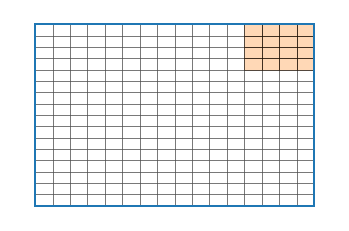

In [10]:
from mesh import QuadMesh
from plot import Plot

plot = Plot()

# Define the Quadrilateral Mesh
mesh = QuadMesh(resolution=(16,16))

# Mark boundary
bnd_fn = lambda x,y: abs(x)<1e-6 or abs(1-x)<1e-6 or abs(y)<1e-6 or abs(1-y)<1e-6 
mesh.mark_region('bnd', bnd_fn, entity_type='half_edge', on_boundary=True)

# Mark averaging region
dmn_fn = lambda x,y: x>=0.75 and x<=1 and y>=0.75 and y<=1
mesh.mark_region('dmn', dmn_fn, entity_type='cell', strict_containment=True, on_boundary=False) 
#cells = mesh.get_region(flag='dmn', entity_type='cell', on_boundary=False, subforest_flag=None)
plot.mesh(mesh, regions=[('bnd','edge'),('dmn','cell')])

#### The Elements and DofHandlers

Next we need to define the approximation space, i.e. the elements. This is done using the ```QuadFE``` class. 
- Here we use piecewise constant elements (```DQ0```) to represent the parameter and piecewise linear elements (```Q1```) for the solution. 
- Since we would like to have multiple different elements associated with the same mesh, we handle the element degrees of freedom by means of a **degrees-of-freedom-handler** or ```DofHandler```, which contains information of the ```mesh``` and the ```element```. 
- For the assembly and function definitions, we may also require ```Basis``` functions. These also encode derivative information. 

In [17]:
from fem import QuadFE, DofHandler, Basis

#
# Elements
#  
Q0 = QuadFE(mesh.dim(), 'DQ0')  # "Discontinuous Quadratic of Degree 0", for parameter 
Q1 = QuadFE(mesh.dim(), 'Q1')  # "Continuous Linear" for output

#
# DofHandlers
# 
dQ0 = DofHandler(mesh,Q0)
dQ1 = DofHandler(mesh,Q1)

#
# Distribute DOFs, i.e. store the dof-indices in the dofhandler
#
dQ0.distribute_dofs()
dQ1.distribute_dofs()

#
# Basis functions for assembly and definition of Nodal functions
#
phi_0 = Basis(dQ0)  # piecewise constant

phi_1 = Basis(dQ1)  # piecewise linear 
phix_1 = Basis(dQ1,'vx')  # piecewise linear first partial w.r.t. x
phiy_1 = Basis(dQ1,'vy')  # piecewise linear first partial w.r.t. y

#### The Gaussian Field

The ```gmrf``` module contains routines to generate a variety of Gaussian random fields.
1. First, the covariance matrix is assembled from a bivariate kernel function using the ```Covariance``` class. The assembly is dependent on the mesh and approximation space (element) associated with the field. 
2. Next we compute its eigendecomposition.
3. Finally we define a Gaussian random field using the ```GaussianField``` class, which allows us to sample, condition, etc.  
4. Samples from the Gaussian field are given as vectors but we can use these to define ```Nodal``` interpolants on the given mesh.  

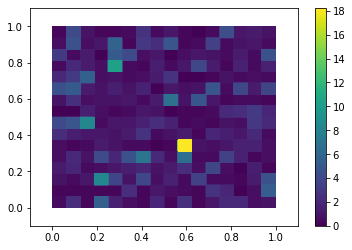

In [20]:
from function import Nodal
from gmrf import Covariance
from gmrf import GaussianField
import numpy as np

#
# Approximate Covariance Matrix
# 
cov = Covariance(dQ0, name='gaussian', parameters={'l':0.01})
cov.compute_eig_decomp()

#
# Define the Gaussian field
# 
q = GaussianField(dQ0.n_dofs(), K=cov)


# Sample Random field and store all samples in a Nodal DQ0 finite element function
n_samples = 100
eq = Nodal(basis=phi_0, data=np.exp(q.sample(n_samples)))

#
# Plot a single sample
#
plot.contour(eq, n_sample=20)

#### Assembly

The weak form of the elliptic PDE is given by

\begin{equation}\label{eq:weak_form}
\iint_D \exp(q) \nabla u \cdot \nabla \phi dx = \iint_D 1 \phi dx, 
\end{equation}

for any test function $\phi$. Approximating $u = \sum_j c_j \phi_j$ in the Galerkin framework, we get $A c = b $, where

\begin{equation}\label{eq:bilinear}
A_{ij} = \iint_D \exp(q) \nabla \phi_j \cdot \nabla \phi_i dx = \iint_D \exp(q) \frac{\partial \phi_j}{\partial x} \frac{\partial \phi_i}{\partial x} + \exp(q)  \frac{\partial \phi_j}{\partial u}\frac{\partial \phi_i}{\partial y} dx
\end{equation}

and 

\begin{equation}\label{eq:linear}
b_i = \iint_D \phi_i dx. 
\end{equation}

The assembly therefore requires a bilinear form $A$ and a linear form $b$. We define each form with the ```Form``` class in the ```assembler``` module. 

Each form requires a ```Kernel``` function, possibly a ```test``` function, and possibly a ```trial``` function (both of which should be ```Basis``` functions). 

> For example, the linear form \ref{eq:linear} is defined by ```Form(1, test=phi_1)```, while the bilinear form $\iint_D \exp(q) \frac{\partial \phi_j}{\partial x} \frac{\partial \phi_i}{\partial x}dx$ is stored as ```Form(eq, test=phix_1, trial=phix_1)```.

1. The object ```Form(kernel)``` is assembled into a scalar. 
2. The linear form ```Form(kernel, test=phi_1)``` is assembled into a vector.
3. The bilinear form ```Form(kernel, test=phix_1, trial=phix_1)``` is assembled into a sparse matrix.

Some forms, such as $\iint_R \phi_i dx$ should only be assembled over a subdomain of the mesh. To do this, use ```Form(1, test=phi_1, flag='dmn')```, where ```dmn``` was the flag marking the region $R$ from earlier. 


> __REMARK:__ When the kernel is a function with multiple samples (such as our function ```eq```), then the relevant form is assembled for all samples.

The ```Assembler``` class handles finite element assembly. For each problem you want to assemble, e.g. the elliptic problem, or the problem of computing $J$, you list all relevant bilinear, linear, and constant forms you need. The assembler will automatically add up the contributions of all bilinear forms into a sparse matrix, those of all the linear forms into a vector, and those of all the constant forms into a scalar. To assemble multiple problems, simply form a ```list``` of all relevant problems.   

In [37]:
from assembler import Assembler
from assembler import Kernel
from assembler import Form

# Define weak form of elliptic problem
problem1 = [Form(eq, test=phix_1, trial=phix_1), 
            Form(eq, test=phiy_1, trial=phiy_1),
            Form(1, test=phi_1)]

# Define integration operator
problem2 = [Form(1,test=phi_1,flag='dmn')]

# Put them together in a list
state = [problem1,problem2]    

# Assemble system
assembler = Assembler(state)  # initialize the assembler
assembler.add_dirichlet('bnd', dir_fn=0, i_problem=0)  # add homogeneous Dirichlet conditions for problem 0  
assembler.assemble()  # assemble


The vector representing the integration operator $\iint_R \phi_i dx$ can be obtained by

In [38]:
J = assembler.get_vector(i_problem=1)

#### Solver

To solve the elliptic equation, you simply specify the problem (default=0), the matrix sample (default=0), and the vector sample for the right hand side (default=0) you want to use, i.e.

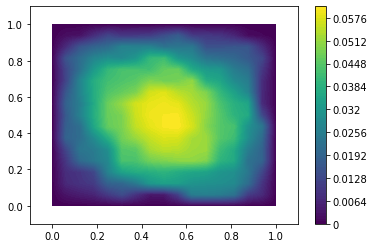

In [39]:
# Solve system
u_vec = assembler.solve()

# Define a finite element function using the solution vector
u = Nodal(basis=phi_1, data=u_vec)

# Plot
plot.contour(u)

#### Quantity of Interest

We can now compute $J = \iint_R u dx$ by taking dot product

In [40]:
J_sample = J.dot(u_vec)

print(J_sample)

0.0006180484835314365
